In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [3]:
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

In [5]:
runname = "run"
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/{runname}/"
budget_diags = ["budgetDiag", "tracer01Diag", "tracer02Diag", "tracer03Diag"]
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=budget_diags, delta_t=delta_t)
ds = ds.sel(time=ds['time'][1::2])
Lx = dx*ds["XC"].size
ds = periodic_extend(ds, ['XC', 'XG'], Lx, [-1,0])
xslice = [500, 500+800]
ds = ds.isel(XC=slice(*xslice), XG=slice(*xslice))
ds, grid = add_rotated_coords(ds, θ)
ds = ds.chunk({'XC': 400, 'XG': 400})
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

ds = ds.assign_coords({'days': (ds['time'].astype('float64')*1.e-9/86400.) - 5000.*(delta_t/60.)})

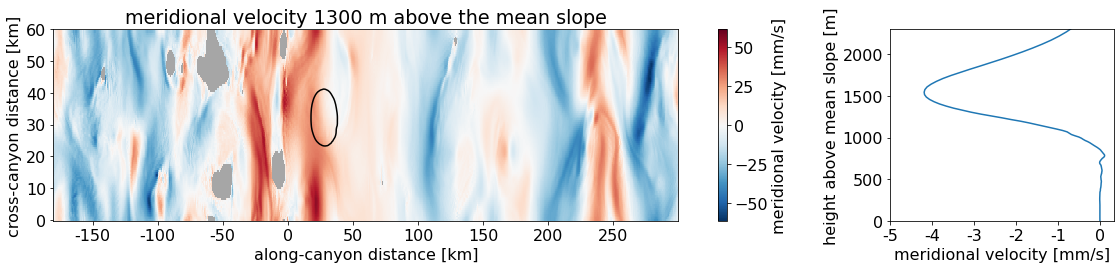

In [6]:
Lx, Ly = ds.XC.size*dx, ds.YC.size*dy

fig = plt.figure(figsize=(16,4))#, constrained_layout=True)
gs = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[0, 0:3])
PC = (ds['VVEL'].where(ds['VVEL']!=0.)*1e3).isel(time=0).isel(Z=30).plot(ax=ax1, cmap=div_cmap)
PC.colorbar.set_label(r"meridional velocity [mm/s]")
ds['TRAC01'].isel(time=0, Z=34).plot.contour(ax=ax1, colors="k", levels=[1e-2])
plt.xlabel("along-canyon distance [km]")
plt.ylabel("cross-canyon distance [km]")
xticks = np.arange(-150, 300, 50)*1e3
plt.xticks(xticks, (xticks*1e-3).astype(np.int64))
yticks = np.arange(0, 70, 10)*1e3
plt.yticks(yticks, (yticks*1e-3).astype(np.int64))
plt.title("meridional velocity 1300 m above the mean slope")

ax2 = fig.add_subplot(gs[0, 3])
((ds['VVEL'].isel(time=0)*ds['dyC']*ds['dxG']).sum(['XC', 'YG'])/(Lx*Ly)).plot(ax=ax2, y='Z')
plt.title("")
plt.xlabel(r"meridional velocity [mm/s]")
xticks = np.arange(-5, 1, 1)
plt.xticks(xticks*1e-3, xticks)
plt.ylabel("height above mean slope [m]")
plt.ylim(0, 2300)

plt.tight_layout()
plt.savefig("../../figures/BBTRE-tracer/S_meridional_flow.png", bbox_inches="tight", dpi=150.)

In [7]:
moments = xr.open_dataset("../../data/BBTRE-tracer/tracer_moments.nc")

In [8]:
tmap = plt.get_cmap("Purples")
Nt = 440//2

# Analysis

In [9]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

In [10]:
for tr in [1,2,3]:
    ds[f'TRAC0{tr}'] = ds[f'TRAC0{tr}'].where(ds[f'TRAC0{tr}'] >= 0., 1.e-40)

In [11]:
TRAC_xy = []
TRAC_xz = []

TRAC_xy_init = []
TRAC_xz_init = []

for tr in range(1,4):
    tmp_xy_init = (ds[f'TRAC0{tr}']*ds['drF']).sum(dim='Z').isel(time=0)
    tmp_xy_init /= tmp_xy_init.max(dim=['XC', 'YC'])
    TRAC_xy_init.append(tmp_xy_init)
    
    tmp_xy = (ds[f'TRAC0{tr}']*ds['drF']).sum(dim='Z').isel(time=slice(Nt-12, Nt+12)).mean('time').compute()
    tmp_xy /= tmp_xy.max(dim=['XC', 'YC'])
    TRAC_xy.append(tmp_xy)

    tmp_xz_init = (ds[f'TRAC0{tr}']*ds['rA']).sum(dim='YC').isel(time=0)
    tmp_xz_init /= tmp_xz_init.max(dim=['XC', 'Z'])
    TRAC_xz_init.append(tmp_xz_init)
    
    tmp_xz = (ds[f'TRAC0{tr}']*ds['rA']).sum(dim='YC').isel(time=slice(Nt-12, Nt+12)).mean('time').compute()
    tmp_xz /= tmp_xz.max(dim=['XC', 'Z'])
    TRAC_xz.append(tmp_xz)

In [12]:
ds = add_hab_coordinates(ds, grid, vert_coord='Z', gridface='C')

dz = 15.
hlevs = np.arange(0., 1500., dz)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


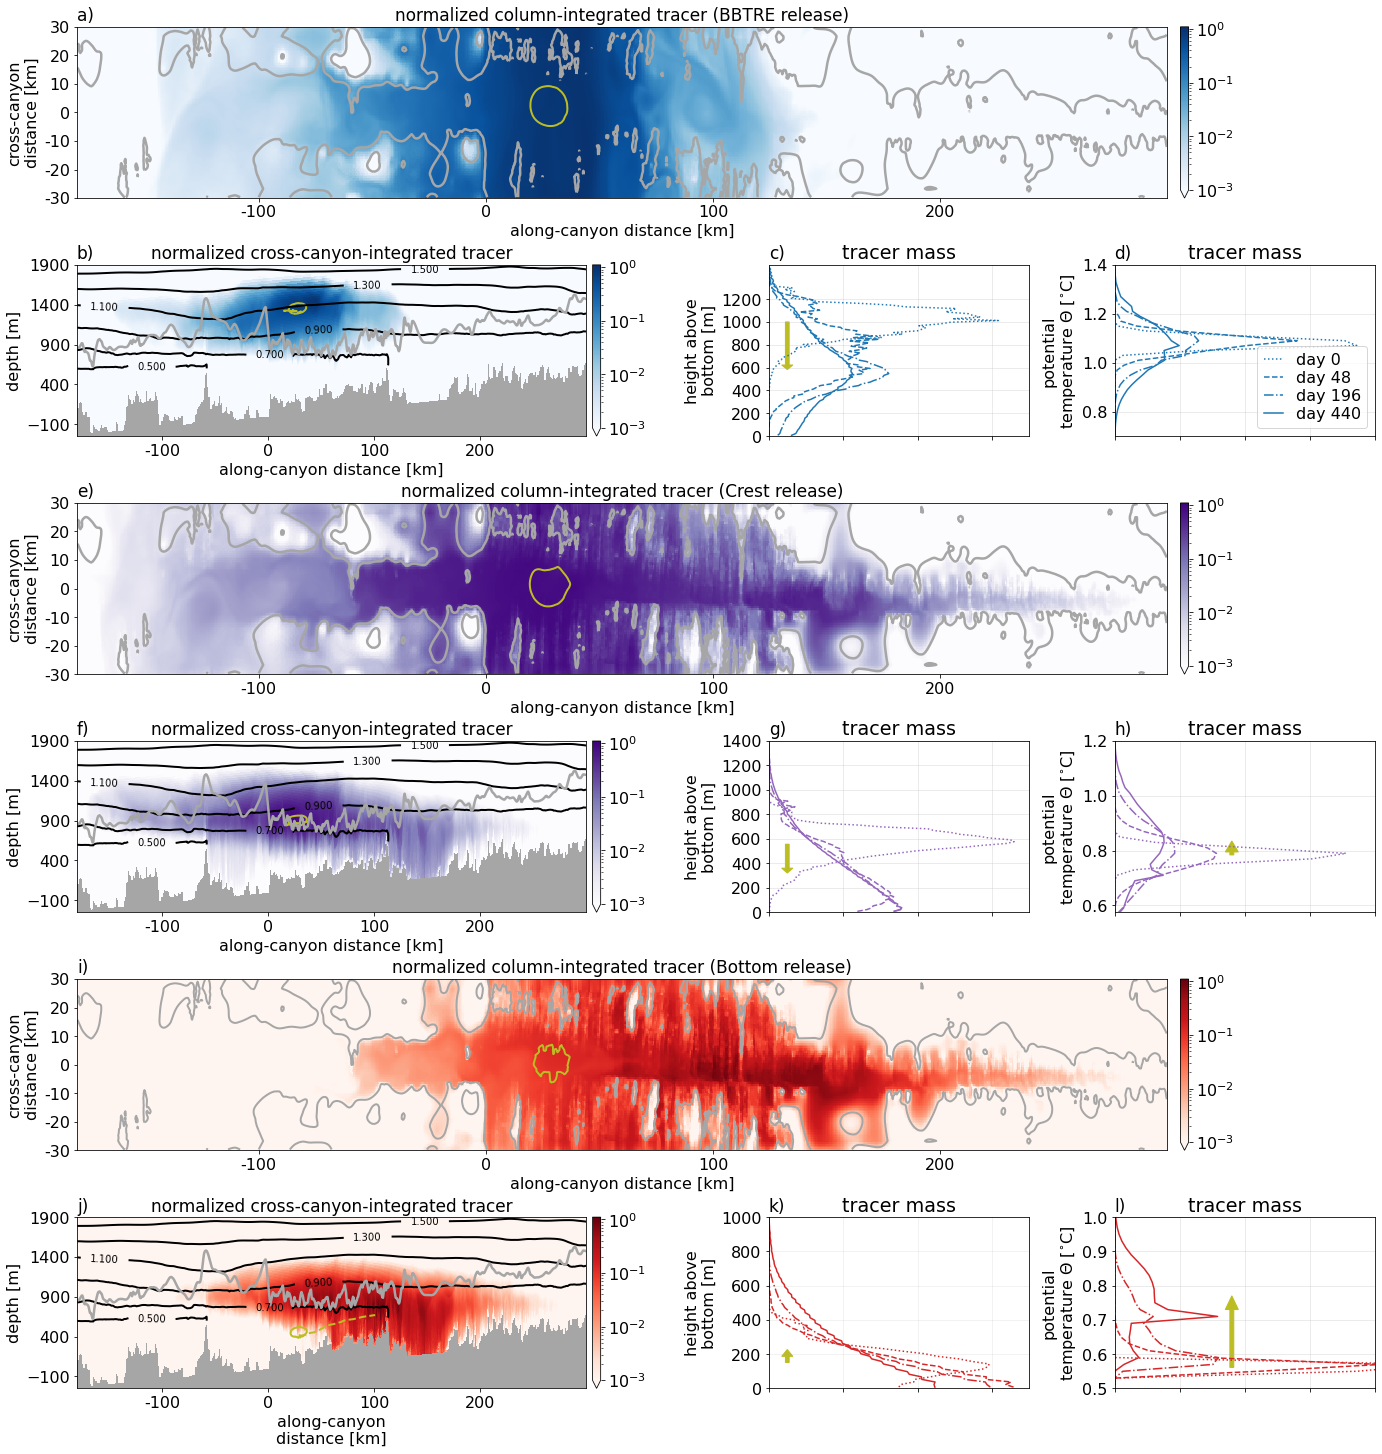

In [13]:
θlevels = np.arange(0.5, 2.5, 0.02)
θlevelsplot = np.arange(0.5, 2.5, 0.2)

ti = -1
xlims = [-1.8e5,3.e5]
ylims1 = [-250,1900]
ylims2 = [-250,1900]

θlw = 2.
blw = 2.5
tlw = 2.0

linestyle = [":", "--", "-.", "-"]
tis = np.int64((np.linspace(0, 21, 4)**2)//2)
tis[-1] = Nt
labels = tis*2

ylim = [[0.7, 1.4], [0.575, 1.2], [0.5, 1.0]]

fig = plt.figure(figsize=(19,20))#, constrained_layout=True)
gs = fig.add_gridspec(6, 4)

####
f_ax1 = fig.add_subplot(gs[0, :])
plt.title("a)", loc="left", fontsize=17)
cmaps = [
    None,
    matplotlib.cm.get_cmap("Blues"),
    matplotlib.cm.get_cmap("Purples"),
    matplotlib.cm.get_cmap("Reds")
]
tcolors=[None, "C0", "C4", "C3"]
tcolor = "C8"
θcolor = "k"
vmax = 1.1

q = TRAC_xy[0].plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[1])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
TRAC_xy_init[0].plot.contour(x='XC', y='YC', levels=[0.1], colors=tcolor, linewidths=tlw)
(ds.H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = blw, levels=[1000, 1500])
plt.title("normalized column-integrated tracer (BBTRE release)", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon\ndistance [km]")
plt.xlim(xlims)

f_ax2 = fig.add_subplot(gs[1, :-2], facecolor=nancol)
plt.title("b)", loc="left", fontsize=17)
q = TRAC_xz[0].plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[1])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(moments['Xbar_Tr01'], moments['Zbar_Tr01'], "--", color=tcolor, lw=tlw)
(ds.H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
TRAC_xz_init[0].plot.contour(x='Xr', y='Zr', levels=[0.1], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=θlevelsplot, linewidths=θlw)
f_ax2.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.title("normalized cross-canyon-integrated tracer", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")
plt.xlim(xlims)
plt.ylim(ylims2)

# HAB
f_ax4 = fig.add_subplot(gs[1, -2])
plt.title("c)", loc="left", fontsize=17)
TrMass = (ds["TRAC01"]*ds["dV"]).isel(time=tis)
histo = histogram(
    ds['Z_habC'].broadcast_like(TrMass),
    bins=[hlevs],
    weights=TrMass,
    dim=('XC', 'YC', 'Z',)
).load();
for i, ti in enumerate(tis):
    histo.isel(time=i).plot(y="Z_habC_bin", color=tcolors[1], linestyle=linestyle[i])
    plt.ylim(0, 1500)
    plt.yticks(np.arange(0., 1400., 200.))
    plt.ylabel("height above\nbottom [m]")
    plt.xlabel("")
    plt.xlim([0,3.5e8])
f_ax4.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.05e8; head_width = 0.15e8; head_length = 40;
plt.arrow(
    width*5, moments['HABbar_Tr01'].isel(time=0).values, 0, (moments['HABbar_Tr01'].isel(time=-1) - moments['HABbar_Tr01'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.xticks(labels=None)
plt.title("tracer mass")

# THETA
f_ax3 = fig.add_subplot(gs[1, -1])
plt.title("d)", loc="left", fontsize=17)
for i, ti in enumerate(tis):
    histo = histogram(
        ds['θ'].isel(time=ti),
        bins=[θlevels],
        weights=(ds[f'TRAC01']*ds['dV']).isel(time=ti)
    )
    histo.plot(y = "θ_bin", color=tcolors[1], linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[0])
    plt.ylabel("potential\n"+r"temperature $\Theta$ [$^{\circ}$C]")
    plt.xlabel("")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.legend(handlelength=1.2, labelspacing=0.2)
f_ax3.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
plt.title("tracer mass")

#####
tr = 2
f_ax5 = fig.add_subplot(gs[2, :])
plt.title("e)", loc="left", fontsize=17)
q = TRAC_xy[tr-1].plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[tr])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
TRAC_xy_init[tr-1].plot.contour(x='XC', y='YC', levels=[0.1], colors=tcolor, linewidths=tlw)
(ds.H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = blw, levels=[1000, 1500])
plt.title("normalized column-integrated tracer (Crest release)", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon\ndistance [km]")
plt.xlim(xlims)

f_ax6 = fig.add_subplot(gs[3, :-2], facecolor=nancol)
plt.title("f)", loc="left", fontsize=17)
q = TRAC_xz[tr-1].plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[tr])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(moments['Xbar_Tr02'], moments['Zbar_Tr02'], "--", color=tcolor, lw=tlw)
(ds.H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
TRAC_xz_init[tr-1].plot.contour(x='Xr', y='Zr', levels=[0.1], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=θlevelsplot, linewidths=θlw)
f_ax6.clabel(CS, inline=1, fontsize=10)
plt.title("normalized cross-canyon-integrated tracer", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")
plt.xlim(xlims)
plt.ylim(ylims2)

# HAB
f_ax8 = fig.add_subplot(gs[3, -2])
plt.title("g)", loc="left", fontsize=17)
TrMass = (ds["TRAC02"]*ds["dV"]).isel(time=tis)
histo = histogram(
    ds['Z_habC'].broadcast_like(TrMass),
    bins=[hlevs],
    weights=TrMass,
    dim=('XC', 'YC', 'Z',)
).load();
for i, ti in enumerate(tis):
    histo.isel(time=i).plot(y="Z_habC_bin", color=tcolors[2], linestyle=linestyle[i])
    plt.ylim(0, 1200)
    plt.yticks(np.arange(0., 1600., 200.))
    plt.ylabel("height above\nbottom [m]")
    plt.xlabel("")
    plt.xlim([0,3.5e8])
plt.title("tracer mass")
f_ax8.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.05e8; head_width = 0.15e8; head_length = 40;
plt.arrow(
    width*5, moments['HABbar_Tr02'].isel(time=0).values, 0, (moments['HABbar_Tr02'].isel(time=-1) - moments['HABbar_Tr02'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.xticks(labels=None)

# THETA
f_ax7 = fig.add_subplot(gs[3, -1])
plt.title("h)", loc="left", fontsize=17)
for i, ti in enumerate(tis):
    histo = histogram(
        ds['θ'].isel(time=ti),
        bins=[θlevels],
        weights=(ds[f'TRAC02']*ds['dV']).isel(time=ti)
    )
    histo.plot(y = "θ_bin", color=tcolors[tr], linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[tr-1])
    plt.ylabel("potential\n"+r"temperature $\Theta$ [$^{\circ}$C]")
    plt.xlabel("")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
f_ax7.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.03e9; head_width = 0.1e9; head_length = 0.04;
plt.arrow(
    width*30, moments['θbar_Tr02'].isel(time=0).values, 0, (moments['θbar_Tr02'].isel(time=-1) - moments['θbar_Tr02'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.title("tracer mass")

#####
tr = 3
f_ax9 = fig.add_subplot(gs[4, :])
plt.title("i)", loc="left", fontsize=17)
q = TRAC_xy[2].plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[3])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
TRAC_xy_init[2].plot.contour(x='XC', y='YC', levels=[0.1], colors=tcolor, linewidths=tlw)
(ds.H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = 2., levels=[1000, 1500])
plt.title("normalized column-integrated tracer (Bottom release)", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon\ndistance [km]")
plt.xlim(xlims)

f_ax10 = fig.add_subplot(gs[5, :-2], facecolor=nancol)
plt.title("j)", loc="left", fontsize=17)
q = TRAC_xz[2].plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=cmaps[3])
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
(ds.H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
plt.ylim(0, 2500)
plt.plot(moments['Xbar_Tr03'], moments['Zbar_Tr03'], "--", color=tcolor, lw=tlw)
TRAC_xz_init[2].plot.contour(x='Xr', y='Zr', levels=[0.1], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=θlevelsplot, linewidths=θlw)
f_ax10.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.title("normalized cross-canyon-integrated tracer", fontsize=17)
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon\ndistance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")
plt.xlim(xlims)
plt.ylim(ylims2)

## HAB
f_ax12 = fig.add_subplot(gs[5, -2])
plt.title("k)", loc="left", fontsize=17)
TrMass = (ds["TRAC03"]*ds["dV"]).isel(time=tis)
histo = histogram(
    ds['Z_habC'].broadcast_like(TrMass),
    bins=[hlevs],
    weights=TrMass,
    dim=('XC', 'YC', 'Z',)
).load();
for i, ti in enumerate(tis):
    histo.isel(time=i).plot(y="Z_habC_bin", color=tcolors[3], linestyle=linestyle[i])
    plt.yticks(np.arange(0., 1200., 200.))
    plt.ylim(0, 1000)
    plt.ylabel("height above\nbottom [m]")
    plt.xlabel("")
    plt.xlim([0,3.5e8])
plt.title("tracer mass")
f_ax12.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.2)
width = 0.05e8; head_width = 0.15e8; head_length = 40;
plt.arrow(
    width*5, moments['HABbar_Tr03'].isel(time=0).values, 0, (moments['HABbar_Tr03'].isel(time=-1) - moments['HABbar_Tr03'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)
plt.xticks(labels=None)

# Theta
f_ax11 = fig.add_subplot(gs[5, -1])
plt.title("l)", loc="left", fontsize=17)
for i, ti in enumerate(tis):
    histo = histogram(
        ds['θ'].isel(time=ti),
        bins=[θlevels],
        weights=(ds[f'TRAC03']*ds['dV']).isel(time=ti)
    )
    histo.plot(y = "θ_bin", color=tcolors[3], linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[tr-1])
    plt.ylabel("potential\n"+r"temperature $\Theta$ [$^{\circ}$C]")
    plt.xlabel("")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.title("tracer mass")
f_ax11.get_xaxis().set_ticklabels([])
plt.grid(True, alpha=0.3)
width = 0.03e9; head_width = 0.1e9; head_length = 0.04;
plt.arrow(
    width*30, moments['θbar_Tr03'].isel(time=0).values, 0, (moments['θbar_Tr03'].isel(time=-1) - moments['θbar_Tr03'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True, color=tcolor
)

plt.tight_layout(pad=0, w_pad=0.75, h_pad=0.3)
plt.savefig("../../figures/BBTRE-tracer/tracer_spreading.png", dpi=150, bbox_inches="tight")